In [ ]:
from evoeval.data import get_evo_eval

evoeval_benchmark = "EvoEval_difficult" # you can pick from 7 different benchmarks!

problems = get_evo_eval(evoeval_benchmark)
list(problems.values())[0].keys()

dict_keys(['task_id', 'prompt', 'canonical_solution', 'entry_point', 'contract', 'inputs', 'parent'])

In [ ]:
# Get both human_eval and evo_eval and then run inference using evo_eval

In [ ]:
from evalplus.data import get_human_eval_plus
humaneval_problems = get_human_eval_plus()
list(humaneval_problems.values())[100]

{'task_id': 'HumanEval/100',
 'prompt': '\ndef make_a_pile(n):\n    """\n    Given a positive integer n, you have to make a pile of n levels of stones.\n    The first level has n stones.\n    The number of stones in the next level is:\n        - the next odd number if n is odd.\n        - the next even number if n is even.\n    Return the number of stones in each level in a list, where element at index\n    i represents the number of stones in the level (i+1).\n\n    Examples:\n    >>> make_a_pile(3)\n    [3, 5, 7]\n    """\n',
 'entry_point': 'make_a_pile',
 'canonical_solution': '\n\n    ans, num = [], n\n    for _ in range(n):\n        ans.append(num)\n        num += 2\n    return ans\n\n',
 'test': 'def check(candidate):\n\n    # Check some simple cases\n    assert candidate(3) == [3, 5, 7], "Test 3"\n    assert candidate(4) == [4,6,8,10], "Test 4"\n    assert candidate(5) == [5, 7, 9, 11, 13]\n    assert candidate(6) == [6, 8, 10, 12, 14, 16]\n    assert candidate(8) == [8, 10, 12

In [ ]:
import json
# Write keys to JSONL file
with open('evo_eval_subtle.jsonl', 'w') as f:
    for key in problems:
        # Write each key as a JSON object on a new line
        json.dump(key, f)
        f.write('\n')

In [ ]:
from openai import OpenAI
from google.colab import userdata
import json
import os

client = OpenAI(api_key = userdata.get('OPENAI_API_KEY'))
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
def get_name_variants(name, num_samples = 10):
    name_variants = [name]
    total_iterations = 0

    while (len(name_variants) < num_samples) and (total_iterations < 100):
        total_iterations += 1
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user",
                          "content": f"""What would be a name for a function which has the same format and meaning as `{name}`? Return your new proposed name for the function as the only text in your response."""
                          }],
                temperature = 1,
                n = 1
            )

            new_name = response.choices[0].message.content
            if new_name not in name_variants:
                name_variants.append(new_name)
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue

    return name_variants

def process_all_names(original_names):
    results = []

    for idx, name in enumerate(original_names):
        print(f"Processing {idx+1}/{len(original_names)}: {name}")
        variants = get_name_variants(name)
        result = {
            "original_name": name,
            "variants": variants
        }
        results.append(result)

        # Write to file after each name is processed
        with open('name_variants.jsonl', 'a') as f:
            f.write(json.dumps(result) + '\n')

    return results

# Process all names
results = process_all_names(original_names)
print("Processing complete. Results saved to 'name_variants.jsonl'")

Processing 1/100: has_close_elements
Processing 2/100: separate_paren_groups
Processing 3/100: truncate_number
Processing 4/100: below_zero
Processing 5/100: mean_absolute_deviation
Processing 6/100: intersperse
Processing 7/100: parse_nested_parens
Processing 8/100: filter_by_substring
Processing 9/100: sum_product
Processing 10/100: rolling_max
Processing 11/100: make_palindrome
Processing 12/100: string_xor
Processing 13/100: longest
Processing 14/100: greatest_common_divisor
Processing 15/100: all_prefixes
Processing 16/100: string_sequence
Processing 17/100: count_distinct_characters
Processing 18/100: parse_music
Processing 19/100: how_many_times
Processing 20/100: sort_numbers
Processing 21/100: find_closest_elements
Processing 22/100: rescale_to_unit
Processing 23/100: filter_integers
Processing 24/100: strlen
Processing 25/100: largest_divisor
Processing 26/100: factorize
Processing 27/100: remove_duplicates
Processing 28/100: flip_case
Processing 29/100: concatenate
Processin

In [ ]:
import json
import copy
def strip_non_alpha(text):
    """
    Strips all characters except letters and underscores from a string.

    Args:
        text (str): Input string to be processed

    Returns:
        str: Processed string containing only letters and underscores
    """
    return ''.join(char for char in text if char.isalpha() or char == '_')

In [ ]:
def create_variant_jsonl(name_variants_file, task_dict, output_file):
    # Read the name variants file
    variants_data = []
    with open(name_variants_file, 'r') as f:
        for line in f:
            variants_data.append(json.loads(line))

    # Open output file
    with open(output_file, 'w') as out_f:
        # For each original entry in variants_data
        for variant_entry in variants_data:
            original_name = variant_entry['original_name']
            variants = variant_entry['variants']

            # Find corresponding task in task_dict
            task_id = None
            task_data = None
            for key, value in task_dict.items():
                if value['entry_point'] == original_name:
                    task_id = key
                    task_data = value
                    break

            if task_data is None:
                continue

            # Get the base number from the task_id (e.g., 99 from EvoEval/99)
            base_num = int(task_id.split('/')[-1])

            # Create a variant entry for each variant name
            for i, variant_name in enumerate(variants):
                # Create a deep copy of the original task data
                new_task = copy.deepcopy(task_data)

                # Update task_id
                new_task['task_id'] = f'EvoEvalVar/{base_num * 10 + i}'

                # Replace entry_point
                new_task['entry_point'] = strip_non_alpha(variant_name)
                new_task["base_input"] = new_task["inputs"]
                new_task["plus_input"] = new_task["inputs"]
                new_task["atol"] = 0
                new_task["base_input"] = new_task["inputs"]

                # Replace all occurrences of original_name in prompt with variant_name
                new_task['prompt'] = new_task['prompt'].replace(original_name, strip_non_alpha(variant_name))

                # Replace all occurrences of original_name in prompt with variant_name
                new_task['canonical_solution'] = new_task['canonical_solution'].replace(original_name, strip_non_alpha(variant_name))

                # Write to output file
                out_f.write(json.dumps(new_task) + '\n')
create_variant_jsonl("name_variants.jsonl", problems, "evo_eval_EvoEval_difficult.jsonl")

In [ ]:
import json
import copy
def create_variant_jsonl(name_variants_file, task_dict, output_file):
    # Read the name variants file
    variants_data = []
    with open(name_variants_file, 'r') as f:
        for line in f:
            variants_data.append(json.loads(line))

    total_lines = 0

    # Open output file
    with open(output_file, 'w') as out_f:
        # For each original entry in variants_data
        for variant_entry in variants_data:
            original_name = variant_entry['original_name']
            variants = variant_entry['variants']

            # Find corresponding task in task_dict
            task_id = None
            task_data = None
            for key, value in task_dict.items():
                if value['entry_point'] == original_name:
                    task_id = key
                    task_data = value
                    break

            if task_data is None:
                continue

            # Get the base number from the task_id (e.g., 99 from EvoEval/99)
            base_num = int(task_id.split('/')[-1])

            # Create a variant entry for each variant name
            for i, variant_name in enumerate(variants):
                total_lines +=1

                # if total_lines > 100:
                #   return None
                # Create a deep copy of the original task data
                new_task = copy.deepcopy(task_data)

                # Update task_id
                new_task['task_id'] = f'HumanEval/{base_num * 10 + i}' # Adding to prevent overlap of IDs  + 993

                # Replace entry_point
                new_task['entry_point'] =strip_non_alpha(variant_name)
                # new_task["atol"] = 0

                # Replace all occurrences of original_name in prompt with variant_name
                new_task['prompt'] = new_task['prompt'].replace(original_name, strip_non_alpha(variant_name))
                new_task['canonical_solution'] = new_task['canonical_solution'].replace(original_name, strip_non_alpha(variant_name))

                # Write to output file
                out_f.write(json.dumps(new_task) + '\n')
create_variant_jsonl("name_variants.jsonl", humaneval_problems, "plus_var.jsonl")

KeyError: 'inputs'

In [ ]:
def merge_jsonl_files(file1_path, file2_path, output_path):
    # Open the output file in write mode
    with open(output_path, 'w', encoding='utf-8') as outfile:
        # Process first file
        with open(file1_path, 'r', encoding='utf-8') as file1:
            for line in file1:
                outfile.write(line)

        # Process second file
        with open(file2_path, 'r', encoding='utf-8') as file2:
            for line in file2:
                outfile.write(line)

# Example usage
file1_path = '/content/evo_eval_subtle_var.jsonl'
file2_path = '/content/plus_var.jsonl'
output_path = '/content/merged_var.jsonl'

try:
    merge_jsonl_files(file1_path, file2_path, output_path)
    print(f"Successfully merged files into {output_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Successfully merged files into /content/merged_var.jsonl


In [ ]:
import gzip
import shutil

def compress_jsonl(input_file, output_file):
    with open(input_file, 'rb') as f_in:
        with gzip.open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

input_file = '/content/evo_eval_EvoEval_difficult.jsonl'
output_file = '/content/evo_eval_EvoEval_difficult.jsonl.gz'
compress_jsonl(input_file, output_file)

In [ ]:
!HUMANEVAL_OVERRIDE_PATH="/content/plus_var.jsonl.gz" evalplus.codegen --model "gpt-4o-mini" --root "/content/" --dataset humaneval --backend openai --n_samples 10 --temperature 1

Setting batch size to 10
Initializing a decoder model: gpt-4o-mini ...
Sanitized code outputs will be saved to /content/humaneval/gpt-4o-mini_openai_temp_1.jsonl
Raw outputs will be saved to /content/humaneval/gpt-4o-mini_openai_temp_1.raw.jsonl
Codegen: HumanEval/0 @ gpt-4o-mini
Codegen: HumanEval/1 @ gpt-4o-mini
Codegen: HumanEval/2 @ gpt-4o-mini
Codegen: HumanEval/3 @ gpt-4o-mini
Codegen: HumanEval/4 @ gpt-4o-mini
Codegen: HumanEval/5 @ gpt-4o-mini
Codegen: HumanEval/6 @ gpt-4o-mini
Codegen: HumanEval/7 @ gpt-4o-mini
Codegen: HumanEval/8 @ gpt-4o-mini
Codegen: HumanEval/9 @ gpt-4o-mini
Codegen: HumanEval/10 @ gpt-4o-mini
Codegen: HumanEval/11 @ gpt-4o-mini
Codegen: HumanEval/12 @ gpt-4o-mini
Codegen: HumanEval/13 @ gpt-4o-mini
Codegen: HumanEval/14 @ gpt-4o-mini
Codegen: HumanEval/15 @ gpt-4o-mini
Codegen: HumanEval/16 @ gpt-4o-mini
Codegen: HumanEval/17 @ gpt-4o-mini
Codegen: HumanEval/18 @ gpt-4o-mini
Codegen: HumanEval/19 @ gpt-4o-mini
Codegen: HumanEval/20 @ gpt-4o-mini
Codegen:

In [ ]:
!HUMANEVAL_OVERRIDE_PATH="/content/evo_eval_subtle_var.jsonl.gz" evalplus.codegen --model "gpt-4o-mini" --root "/content/sample_data/evo" --dataset humaneval --backend openai --n_samples 10 --temperature 1

Setting batch size to 10
Initializing a decoder model: gpt-4o-mini ...
Sanitized code outputs will be saved to /content/sample_data/evo/humaneval/gpt-4o-mini_openai_temp_1.jsonl
Raw outputs will be saved to /content/sample_data/evo/humaneval/gpt-4o-mini_openai_temp_1.raw.jsonl
Codegen: EvoEvalVar/0 @ gpt-4o-mini
Codegen: EvoEvalVar/1 @ gpt-4o-mini
Codegen: EvoEvalVar/2 @ gpt-4o-mini
Codegen: EvoEvalVar/3 @ gpt-4o-mini
Codegen: EvoEvalVar/4 @ gpt-4o-mini
Codegen: EvoEvalVar/5 @ gpt-4o-mini
Codegen: EvoEvalVar/6 @ gpt-4o-mini
Codegen: EvoEvalVar/7 @ gpt-4o-mini
Codegen: EvoEvalVar/8 @ gpt-4o-mini
Codegen: EvoEvalVar/9 @ gpt-4o-mini
Codegen: EvoEvalVar/10 @ gpt-4o-mini
Codegen: EvoEvalVar/11 @ gpt-4o-mini
Codegen: EvoEvalVar/12 @ gpt-4o-mini
Codegen: EvoEvalVar/13 @ gpt-4o-mini
Codegen: EvoEvalVar/14 @ gpt-4o-mini
Codegen: EvoEvalVar/15 @ gpt-4o-mini
Codegen: EvoEvalVar/16 @ gpt-4o-mini
Codegen: EvoEvalVar/17 @ gpt-4o-mini
Codegen: EvoEvalVar/18 @ gpt-4o-mini
Codegen: EvoEvalVar/19 @ gpt-

In [ ]:
!HUMANEVAL_OVERRIDE_PATH="/content/evo_eval_EvoEval_difficult.jsonl.gz" evoeval.evaluate --dataset humaneval --samples "/content/difficult_samples.jsonl"

Computing expected output...
Traceback (most recent call last):
  File "/usr/local/bin/evoeval.evaluate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 369, in main
    evaluate(args)
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 167, in evaluate
    expected_output = get_groundtruth(
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 53, in get_groundtruth
    oracle["base"], oracle["base_time"] = trusted_exec(
  File "/usr/local/lib/python3.10/dist-packages/evalplus/gen/util/__init__.py", line 19, in trusted_exec
    ret.append(fn(*inp))
TypeError: separate_paren_groups() takes from 1 to 2 positional arguments but 26 were given


In [ ]:
!EVOEVAL_OVERRIDE_PATH="/content/" evoeval.evaluate --dataset evo_eval_EvoEval_difficult --samples "difficult_samples.jsonl"

Computing expected output...
Traceback (most recent call last):
  File "/usr/local/bin/evoeval.evaluate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 369, in main
    evaluate(args)
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 186, in evaluate
    expected_output = get_groundtruth(
  File "/usr/local/lib/python3.10/dist-packages/evoeval/evaluate.py", line 53, in get_groundtruth
    oracle["base"], oracle["base_time"] = trusted_exec(
  File "/usr/local/lib/python3.10/dist-packages/evalplus/gen/util/__init__.py", line 19, in trusted_exec
    ret.append(fn(*inp))
  File "<string>", line 19, in sum
TypeError: sum() missing 1 required positional argument: 'n'


In [ ]:
# Run results for different dataset versions

In [ ]:
import json
import pandas as pd
from pathlib import Path

# Read the JSON file
file_path = "/content/sample_data/evo/humaneval/gpt-4o-mini_openai_temp_1_eval_results.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Create a list to store all rows
rows = []

for problem_id, generations in data['eval'].items():
    # Extract the number from the problem_id (e.g., "HumanEval/42" -> 42)
    problem_num = int(problem_id.split('/')[-1])
    # Calculate the base_problem_id by rounding down to nearest 10
    base_num = (problem_num // 10)
    # Construct the base_problem_id
    base_problem_id = f"{problem_id.split('/')[0]}/{base_num}"

    for gen_num, generation in enumerate(generations, 1):
        row = {
            'problem_id': problem_id,
            'base_problem_id': base_problem_id,
            'generation_number': gen_num,
            'solution': generation['solution'],
            'base_status': generation['base_status'],
            'plus_status': generation['plus_status'],
            'base_fail_tests': generation['base_fail_tests'],
            'plus_fail_tests': generation['plus_fail_tests']
        }
        rows.append(row)

results_df = pd.DataFrame(rows)
results_df

,problem_id,base_problem_id,generation_number,solution,base_status,plus_status,base_fail_tests,plus_fail_tests
0,EvoEvalVar/0,EvoEvalVar/0,1,from typing import List\ndef has_close_element...,pass,None,[],[]
1,EvoEvalVar/0,EvoEvalVar/0,2,from typing import List\ndef has_close_element...,pass,None,[],[]
2,EvoEvalVar/0,EvoEvalVar/0,3,from typing import List\ndef has_close_element...,pass,None,[],[]
3,EvoEvalVar/0,EvoEvalVar/0,4,from typing import List\ndef has_close_element...,pass,None,[],[]
4,EvoEvalVar/0,EvoEvalVar/0,5,from typing import List\ndef has_close_element...,pass,None,[],[]
...,...,...,...,...,...,...,...,...
6365,EvoEvalVar/992,EvoEvalVar/99,6,def nearest_integer(value):\n '''\n Crea...,fail,None,[[14.5]],[]
6366,EvoEvalVar/992,EvoEvalVar/99,7,def nearest_integer(value):\n '''\n Crea...,fail,None,[[14.5]],[]
6367,EvoEvalVar/992,EvoEvalVar/99,8,def nearest_integer(value):\n '''\n Crea...,pass,None,[],[]
6368,EvoEvalVar/992,EvoEvalVar/99,9,def nearest_integer(value):\n '''\n Crea...,pass,None,[],[]


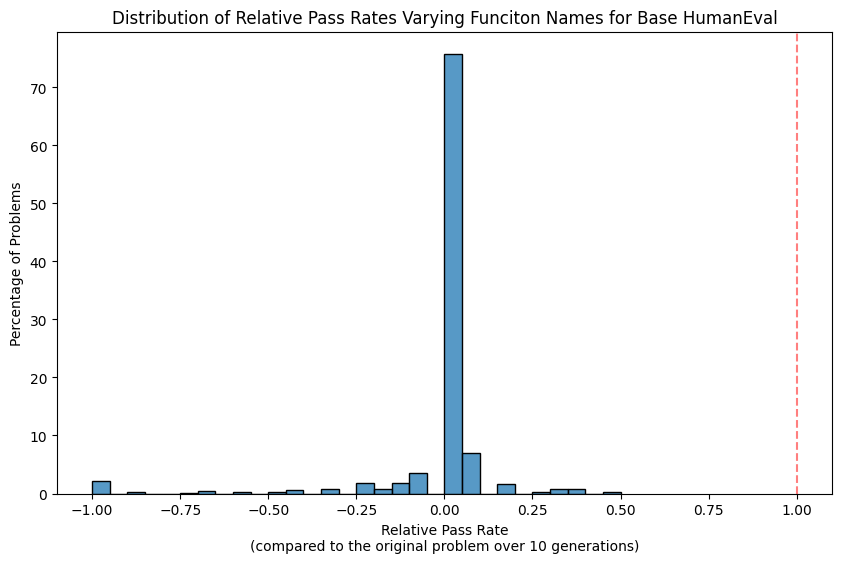


Summary Statistics of Relative Pass Rates:
count    637.000000
mean      -0.030141
std        0.190668
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: relative_pass_rate, dtype: float64


In [ ]:
# Calculate pass rate for each problem_id
pass_rates = (results_df
              .groupby('problem_id')['base_status']
              .apply(lambda x: (x == 'pass').mean())
              .reset_index(name='pass_rate'))

# Add base_problem_id to pass_rates
pass_rates['base_problem_id'] = pass_rates['problem_id'].apply(
    lambda x: f"{x.split('/')[0]}/{int(x.split('/')[-1]) // 10}")

# Get the first problem_id's pass rate for each base_problem_id
base_rates = pass_rates.groupby('base_problem_id').first().reset_index()
base_rates = base_rates[['base_problem_id', 'pass_rate']].rename(
    columns={'pass_rate': 'base_pass_rate'})

# Merge to calculate relative pass rates
pass_rates = pass_rates.merge(base_rates, on='base_problem_id')
pass_rates['relative_pass_rate'] = pass_rates['pass_rate'] - pass_rates['base_pass_rate']

# Create the distribution plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=pass_rates, x='relative_pass_rate', bins=30, stat='percent')
plt.title('Distribution of Relative Pass Rates Varying Funciton Names for Base HumanEval')
plt.xlabel('Relative Pass Rate\n(compared to the original problem over 10 generations)')
plt.ylabel('Percentage of Problems')

# Add vertical line at x=1 for reference
plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)

plt.show()

# Print some summary statistics
print("\nSummary Statistics of Relative Pass Rates:")
print(pass_rates['relative_pass_rate'].describe())

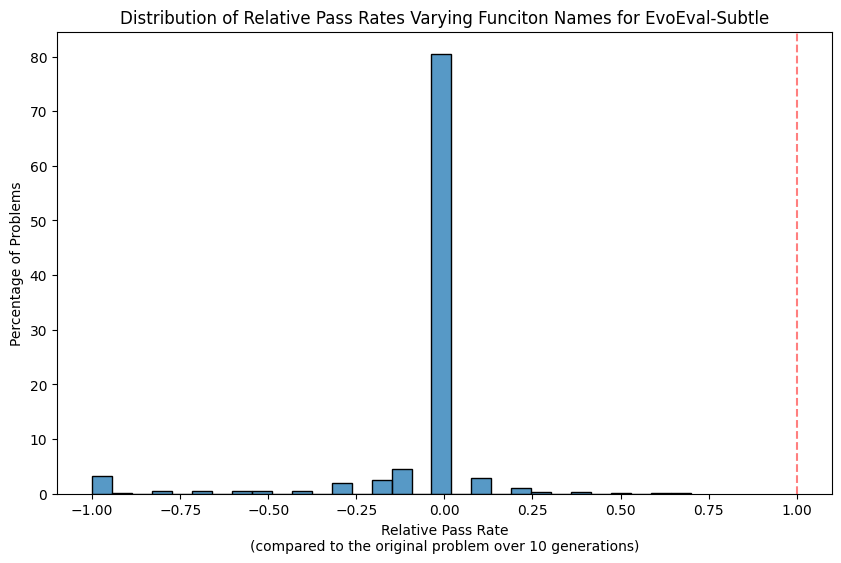


Summary Statistics of Relative Pass Rates:
count    756.000000
mean      -0.052249
std        0.210475
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.700000
Name: relative_pass_rate, dtype: float64


In [ ]:
import json
import pandas as pd
from pathlib import Path

# Read the JSON file
file_path = "/content/human_eval_evo_eval_results.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Create a list to store all rows
rows = []

for problem_id, generations in data['eval'].items():
    # Extract the number from the problem_id (e.g., "HumanEval/42" -> 42)
    problem_num = int(problem_id.split('/')[-1])
    # Calculate the base_problem_id by rounding down to nearest 10
    base_num = (problem_num // 10)
    # Construct the base_problem_id
    base_problem_id = f"{problem_id.split('/')[0]}/{base_num}"

    for gen_num, generation in enumerate(generations, 1):
        row = {
            'problem_id': problem_id,
            'base_problem_id': base_problem_id,
            'generation_number': gen_num,
            'solution': generation['solution'],
            'base_status': generation['base_status'],
            'plus_status': generation['plus_status'],
            'base_fail_tests': generation['base_fail_tests'],
            'plus_fail_tests': generation['plus_fail_tests']
        }
        rows.append(row)

results_df = pd.DataFrame(rows)

# Calculate pass rate for each problem_id
pass_rates = (results_df
              .groupby('problem_id')['base_status']
              .apply(lambda x: (x == 'pass').mean())
              .reset_index(name='pass_rate'))

# Add base_problem_id to pass_rates
pass_rates['base_problem_id'] = pass_rates['problem_id'].apply(
    lambda x: f"{x.split('/')[0]}/{int(x.split('/')[-1]) // 10}")

# Get the first problem_id's pass rate for each base_problem_id
base_rates = pass_rates.groupby('base_problem_id').first().reset_index()
base_rates = base_rates[['base_problem_id', 'pass_rate']].rename(
    columns={'pass_rate': 'base_pass_rate'})

# Merge to calculate relative pass rates
pass_rates = pass_rates.merge(base_rates, on='base_problem_id')
pass_rates['relative_pass_rate'] = pass_rates['pass_rate'] - pass_rates['base_pass_rate']

# Create the distribution plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=pass_rates, x='relative_pass_rate', bins=30, stat='percent')
plt.title('Distribution of Relative Pass Rates Varying Funciton Names for EvoEval-Subtle')
plt.xlabel('Relative Pass Rate\n(compared to the original problem over 10 generations)')
plt.ylabel('Percentage of Problems')

# Add vertical line at x=1 for reference
plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)

plt.show()

# Print some summary statistics
print("\nSummary Statistics of Relative Pass Rates:")
print(pass_rates['relative_pass_rate'].describe())

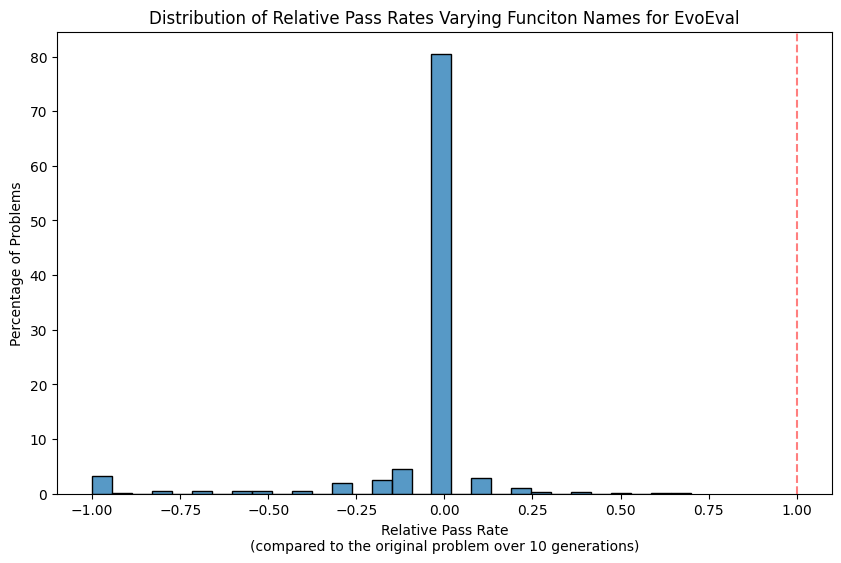


Summary Statistics of Relative Pass Rates:
count    756.000000
mean      -0.052249
std        0.210475
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.700000
Name: relative_pass_rate, dtype: float64


In [ ]:
import json
import pandas as pd
from pathlib import Path

# Read the JSON file
file_path = "/content/human_eval_evo_eval_results.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Create a list to store all rows
rows = []

for problem_id, generations in data['eval'].items():
    # Extract the number from the problem_id (e.g., "HumanEval/42" -> 42)
    problem_num = int(problem_id.split('/')[-1])
    # Calculate the base_problem_id by rounding down to nearest 10
    base_num = (problem_num // 10)
    # Construct the base_problem_id
    base_problem_id = f"{problem_id.split('/')[0]}/{base_num}"

    for gen_num, generation in enumerate(generations, 1):
        row = {
            'problem_id': problem_id,
            'base_problem_id': base_problem_id,
            'generation_number': gen_num,
            'solution': generation['solution'],
            'base_status': generation['base_status'],
            'plus_status': generation['plus_status'],
            'base_fail_tests': generation['base_fail_tests'],
            'plus_fail_tests': generation['plus_fail_tests']
        }
        rows.append(row)

results_df = pd.DataFrame(rows)

# Calculate pass rate for each problem_id
pass_rates = (results_df
              .groupby('problem_id')['base_status']
              .apply(lambda x: (x == 'pass').mean())
              .reset_index(name='pass_rate'))

# Add base_problem_id to pass_rates
pass_rates['base_problem_id'] = pass_rates['problem_id'].apply(
    lambda x: f"{x.split('/')[0]}/{int(x.split('/')[-1]) // 10}")

# Get the first problem_id's pass rate for each base_problem_id
base_rates = pass_rates.groupby('base_problem_id').first().reset_index()
base_rates = base_rates[['base_problem_id', 'pass_rate']].rename(
    columns={'pass_rate': 'base_pass_rate'})

# Merge to calculate relative pass rates
pass_rates = pass_rates.merge(base_rates, on='base_problem_id')
pass_rates['relative_pass_rate'] = pass_rates['pass_rate'] - pass_rates['base_pass_rate']

# Create the distribution plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=pass_rates, x='relative_pass_rate', bins=30, stat='percent')
plt.title('Distribution of Relative Pass Rates Varying Funciton Names for EvoEval')
plt.xlabel('Relative Pass Rate\n(compared to the original problem over 10 generations)')
plt.ylabel('Percentage of Problems')

# Add vertical line at x=1 for reference
plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)

plt.show()

# Print some summary statistics
print("\nSummary Statistics of Relative Pass Rates:")
print(pass_rates['relative_pass_rate'].describe())

In [ ]:
!HUMANEVAL_OVERRIDE_PATH="/content/merged_var.jsonl.gz" evalplus.codegen --model "gpt-4o-mini" --root "/content/" --dataset humaneval --backend openai --n_samples 2 --temperature 1

Setting batch size to 2
Initializing a decoder model: gpt-4o-mini ...
Sanitized code outputs will be saved to /content/humaneval/gpt-4o-mini_openai_temp_1.jsonl
Raw outputs will be saved to /content/humaneval/gpt-4o-mini_openai_temp_1.raw.jsonl
Codegen: EvoEvalVar/0 @ gpt-4o-mini
Codegen: EvoEvalVar/1 @ gpt-4o-mini
Codegen: EvoEvalVar/2 @ gpt-4o-mini
Codegen: EvoEvalVar/3 @ gpt-4o-mini
Codegen: EvoEvalVar/4 @ gpt-4o-mini
Codegen: EvoEvalVar/5 @ gpt-4o-mini
Codegen: EvoEvalVar/6 @ gpt-4o-mini
Codegen: EvoEvalVar/7 @ gpt-4o-mini
Codegen: EvoEvalVar/8 @ gpt-4o-mini
Codegen: EvoEvalVar/9 @ gpt-4o-mini
Codegen: EvoEvalVar/10 @ gpt-4o-mini
Codegen: EvoEvalVar/11 @ gpt-4o-mini
Codegen: EvoEvalVar/12 @ gpt-4o-mini
Codegen: EvoEvalVar/13 @ gpt-4o-mini
Codegen: EvoEvalVar/14 @ gpt-4o-mini
Codegen: EvoEvalVar/15 @ gpt-4o-mini
Codegen: EvoEvalVar/16 @ gpt-4o-mini
Codegen: EvoEvalVar/17 @ gpt-4o-mini
Codegen: EvoEvalVar/18 @ gpt-4o-mini
Codegen: EvoEvalVar/19 @ gpt-4o-mini
Codegen: EvoEvalVar/20 @ 

In [ ]:
!HUMANEVAL_OVERRIDE_PATH="/content/plus_var.jsonl.gz" evalplus.evaluate --dataset humaneval --samples /content/humaneval/gpt-4o-mini_openai_temp_1.jsonl

Traceback (most recent call last):
  File "/usr/local/bin/evalplus.evaluate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/evalplus/evaluate.py", line 359, in main
    Fire(evaluate)
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 135, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 468, in _Fire
    component, remaining_args = _CallAndUpdateTrace(
  File "/usr/local/lib/python3.10/dist-packages/fire/core.py", line 684, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/evalplus/evaluate.py", line 168, in evaluate
    problems = get_human_eval_plus(
  File "/usr/local/lib/python3.10/dist-packages/evalplus/data/humaneval.py", line 65, in get_human_eval_plus
    completeness_check("HumanEval+", plus)
  File "/usr/local/lib/python3.10/dist-packages/evalplus/data/u

In [ ]:
list(problems.values())[99]

{'task_id': 'EvoEval/99',
 'prompt': '\ndef closest_integer(value):\n    \'\'\'\n    Create a function that takes a value (string) representing a number\n    and returns the closest integer to it. If the number is equidistant\n    from two integers, round it towards zero.\n\n    Examples\n    >>> closest_integer("10")\n    10\n    >>> closest_integer("15.3")\n    15\n\n    Note:\n    Rounding towards zero means that if the given number is equidistant\n    from two integers, the one you should return is the one that is the\n    closest to zero. For example closest_integer("14.5") should\n    return 14 and closest_integer("-14.5") should return -14.\n    \'\'\'\n',
 'canonical_solution': '\n\n\n    def rounding(val):\n        if abs(val - int(val)) != 0.5:\n            return round(val)\n        if val > 0:\n            return int(val)\n        else:\n            return int(val)\n    return rounding(float(value))\n\n',
 'entry_point': 'closest_integer',
 'contract': '',
 'inputs': ["'10'

In [ ]:
HUMANEVAL_OVERRIDE_PATH="/path/to/HumanEvalPlus.jsonl.gz" evalplus.evaluate --dataset humaneval --samples samples.jsonl

{'task_id': 'EvoEval/1',
 'prompt': 'from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n    separate those group into separate strings and return the list of those.\n    Separate groups are balanced (each open brace is properly closed) and not nested within each other\n    Ignore any spaces in the input string. \n    Return the list in ascending alphabetical order \n    >>> separate_paren_groups(\'( ) (( )) (( )( ))\')\n    [\'(()())\', \'(())\', \'()\']\n    """\n',
 'canonical_solution': '\n\n\n    cnt, group, results = 0, "", []\n    for ch in paren_string:\n        if ch == "(": cnt += 1\n        if ch == ")": cnt -= 1\n        if ch != " ": group += ch\n        if cnt == 0:\n            if group != "": results.append(group)\n            group = ""\n    return sorted(results)\n\n',
 'entry_point': 'separate_paren_groups',
 'contract': '

In [ ]:
# 💡 If you are storing codes in jsonl:

evalplus.sanitize --samples samples.jsonl
# Sanitized code will be produced to `samples-sanitized.jsonl`

# 💡 If you are storing codes in directories:
evalplus.sanitize --samples /path/to/vicuna-[??]b_temp_[??]
# Sanitized code will be produced to `/path/to/vicuna-[??]b_temp_[??]-sanitized`

In [ ]:
evalplus.evaluate --dataset [humaneval|mbpp] --samples samples.jsonl

In [ ]:
# Need code that given a list of EvoEval or HumanEval problems and solutions can get performance

In [ ]:
evoeval.evaluate --dataset EvoEval_difficult --samples EvoEval_difficult_samples.jsonl

In [ ]:
export OPENAI_API_KEY="[YOUR_API_KEY]"
evalplus.evaluate --model "gpt-4o-mini"            \
                  --dataset [humaneval|mbpp]  \
                  --backend openai            \
                  --greedy